# Integration of membrane protein, transport of substrates, and two-component sensing using BioCRNpyler membrane components and mechanism
Consider the following substrate transport steps:
1. Expression of membrane protein: G + EnergyTXTL $\rightarrow$ membrane_protein (MP)
2. Integration of membrane protein in membrane: MP $\rightarrow$ integral_membrane_protein (IMP)
3. Diffusion, transport across membrane, or a memebrane sensor

Types of membrane transport mechanisms:
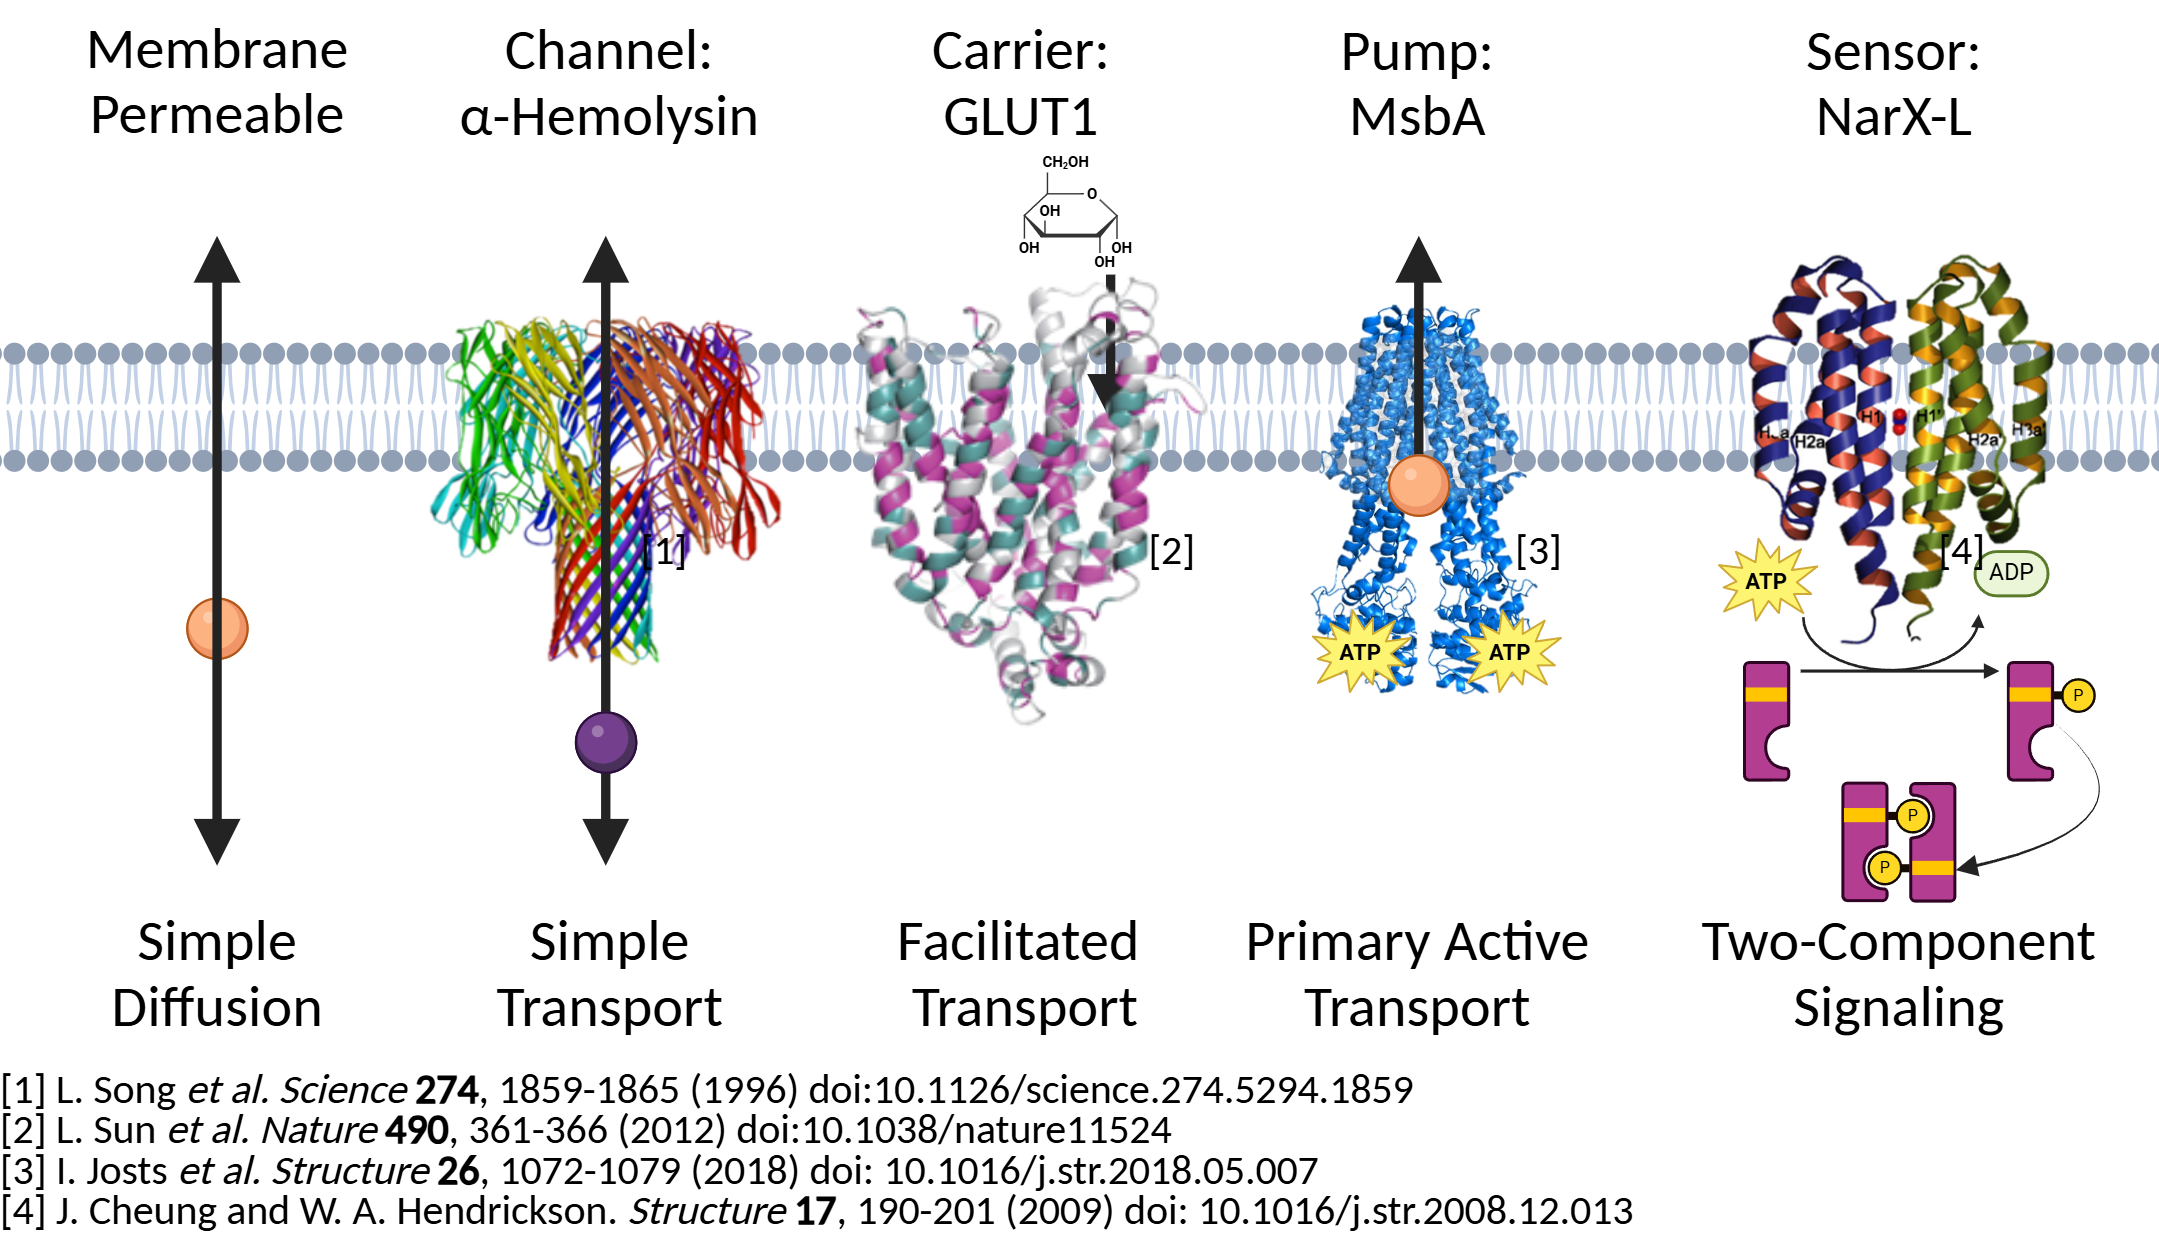
To create these models, we need to express the membrane protein. Next, we need to identify the membrane protein monomer, indicate the membrane transport mechanism, and its transport direction. If the protein functions as part of a two-component sensor (TCS), no transport activity will occur but the membrane sensor will auto-phosphorylate and subsequently phosphorylation the response protein.

### Packages

In [1]:
import numpy as np
%matplotlib inline
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
from bokeh.themes import Theme
from bokeh.layouts import row

# Modules needed from Bokeh.
from bokeh.io import output_file, show
from bokeh.plotting import gridplot,figure
from bokeh.models import LinearAxis, Range1d

colors2 = bokeh.palettes.Colorblind[8]

try:
    import dnaplotlib as dpl
    dpl_enabled = True
except (ModuleNotFoundError,ImportError) as e:
    dpl_enabled = False
    
from bokeh.io import export_png

Loading BokehJS ...

In [2]:
def create_custom_plot(title_text, x_max=8,y_max=2, yname=None):
    custom_plot = figure(
        toolbar_location='right',
        outline_line_color=None,
        min_border_right=10,
        height=400,
        width=400,
    )

    custom_plot.title.text = title_text
    custom_plot.xaxis.axis_label = 'Time (hours)'
    custom_plot.yaxis.axis_label = yname
    custom_plot.y_range = Range1d(0, y_max)
    custom_plot.x_range = Range1d(0, x_max)
    custom_plot.outline_line_color = None

    # custom_plot.yaxis
    custom_plot.ygrid.visible = False
    custom_plot.yaxis.axis_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font = 'Work Sans'
    custom_plot.yaxis.axis_label_standoff = 15
    custom_plot.yaxis.axis_label_text_font_style = 'normal'

    # custom_plot.xaxis
    custom_plot.xgrid.visible = False
    custom_plot.xaxis.axis_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font = 'Work Sans'
    custom_plot.xaxis.axis_label_standoff = 15
    custom_plot.xaxis.axis_label_text_font_style = 'normal'

    # custom_plot.title
    custom_plot.title.text_font_size = '18pt'
    custom_plot.title.align = 'left'
    custom_plot.title.offset = -50.0

    return custom_plot

# Example 0: Simple diffusion thorugh membrane (membrane permeable)
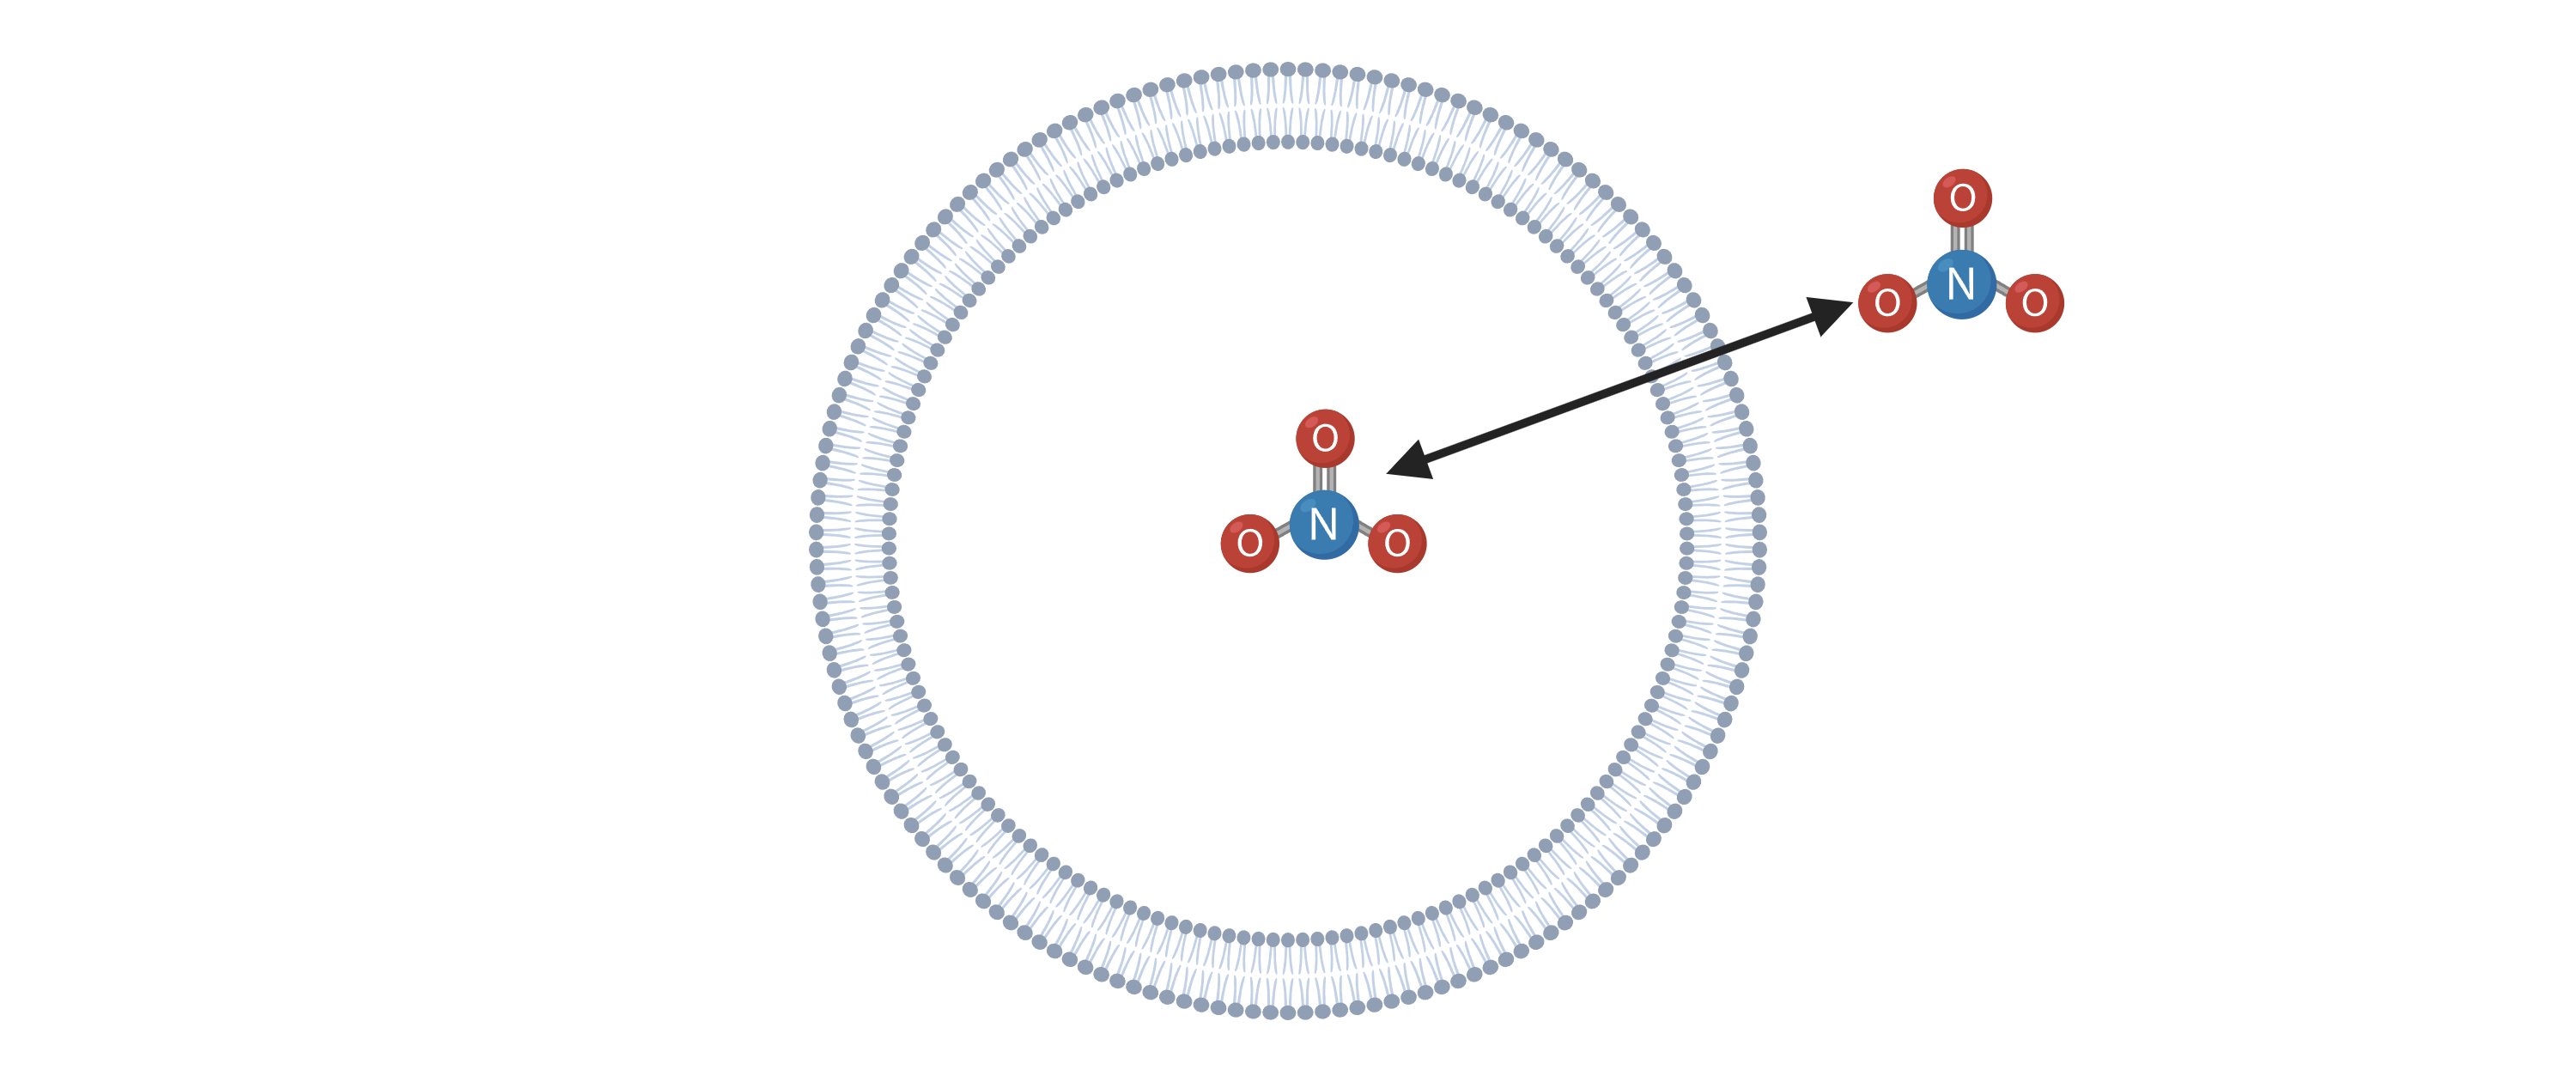
Consider the following diffusion step:
1. Diffusion of small molecules (i.e. Nitrate):
\begin{align}
    NO3_{internal} \rightleftharpoons NO3_{external}
\end{align}

## Define diffusible molecule

In [3]:
NO3=DiffusibleMolecule('NO3')

default_parameters = {"k_diff":2e-4}
mech_cat = Simple_Diffusion() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}
M1= Mixture("Default Param Pathway", components = [NO3], parameters = default_parameters, mechanisms = default_mechanisms)
CRN0 = M1.compile_crn()

NameError: name 'DiffusibleMolecule' is not defined

In [ ]:
#Inital conditions
x0_dict= {'NO3_Internal':2}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 100)

#Run Simulation
R = CRN0.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

In [ ]:
#Plot alpha-hemolysin protien and the multiple configurations
p2 =create_custom_plot("NO3 Diffusion", x_max=8,y_max= 2, yname='NO3 (uM)')
p2.line(R["time"]/3600,  R['NO3_Internal'], line_width = 3, line_alpha=.5, color='red', legend_label='Internal')
p2.line(R["time"]/3600,  R['NO3_External'], line_width = 3, line_alpha=.5,color='yellow',legend_label='External')

# Display the layout
show(p2)

# Example 1: Integration of membrane protein (monomer) and passive diffusion by a membrane channel (ex. IPTG and $\alpha$-hemolysin)
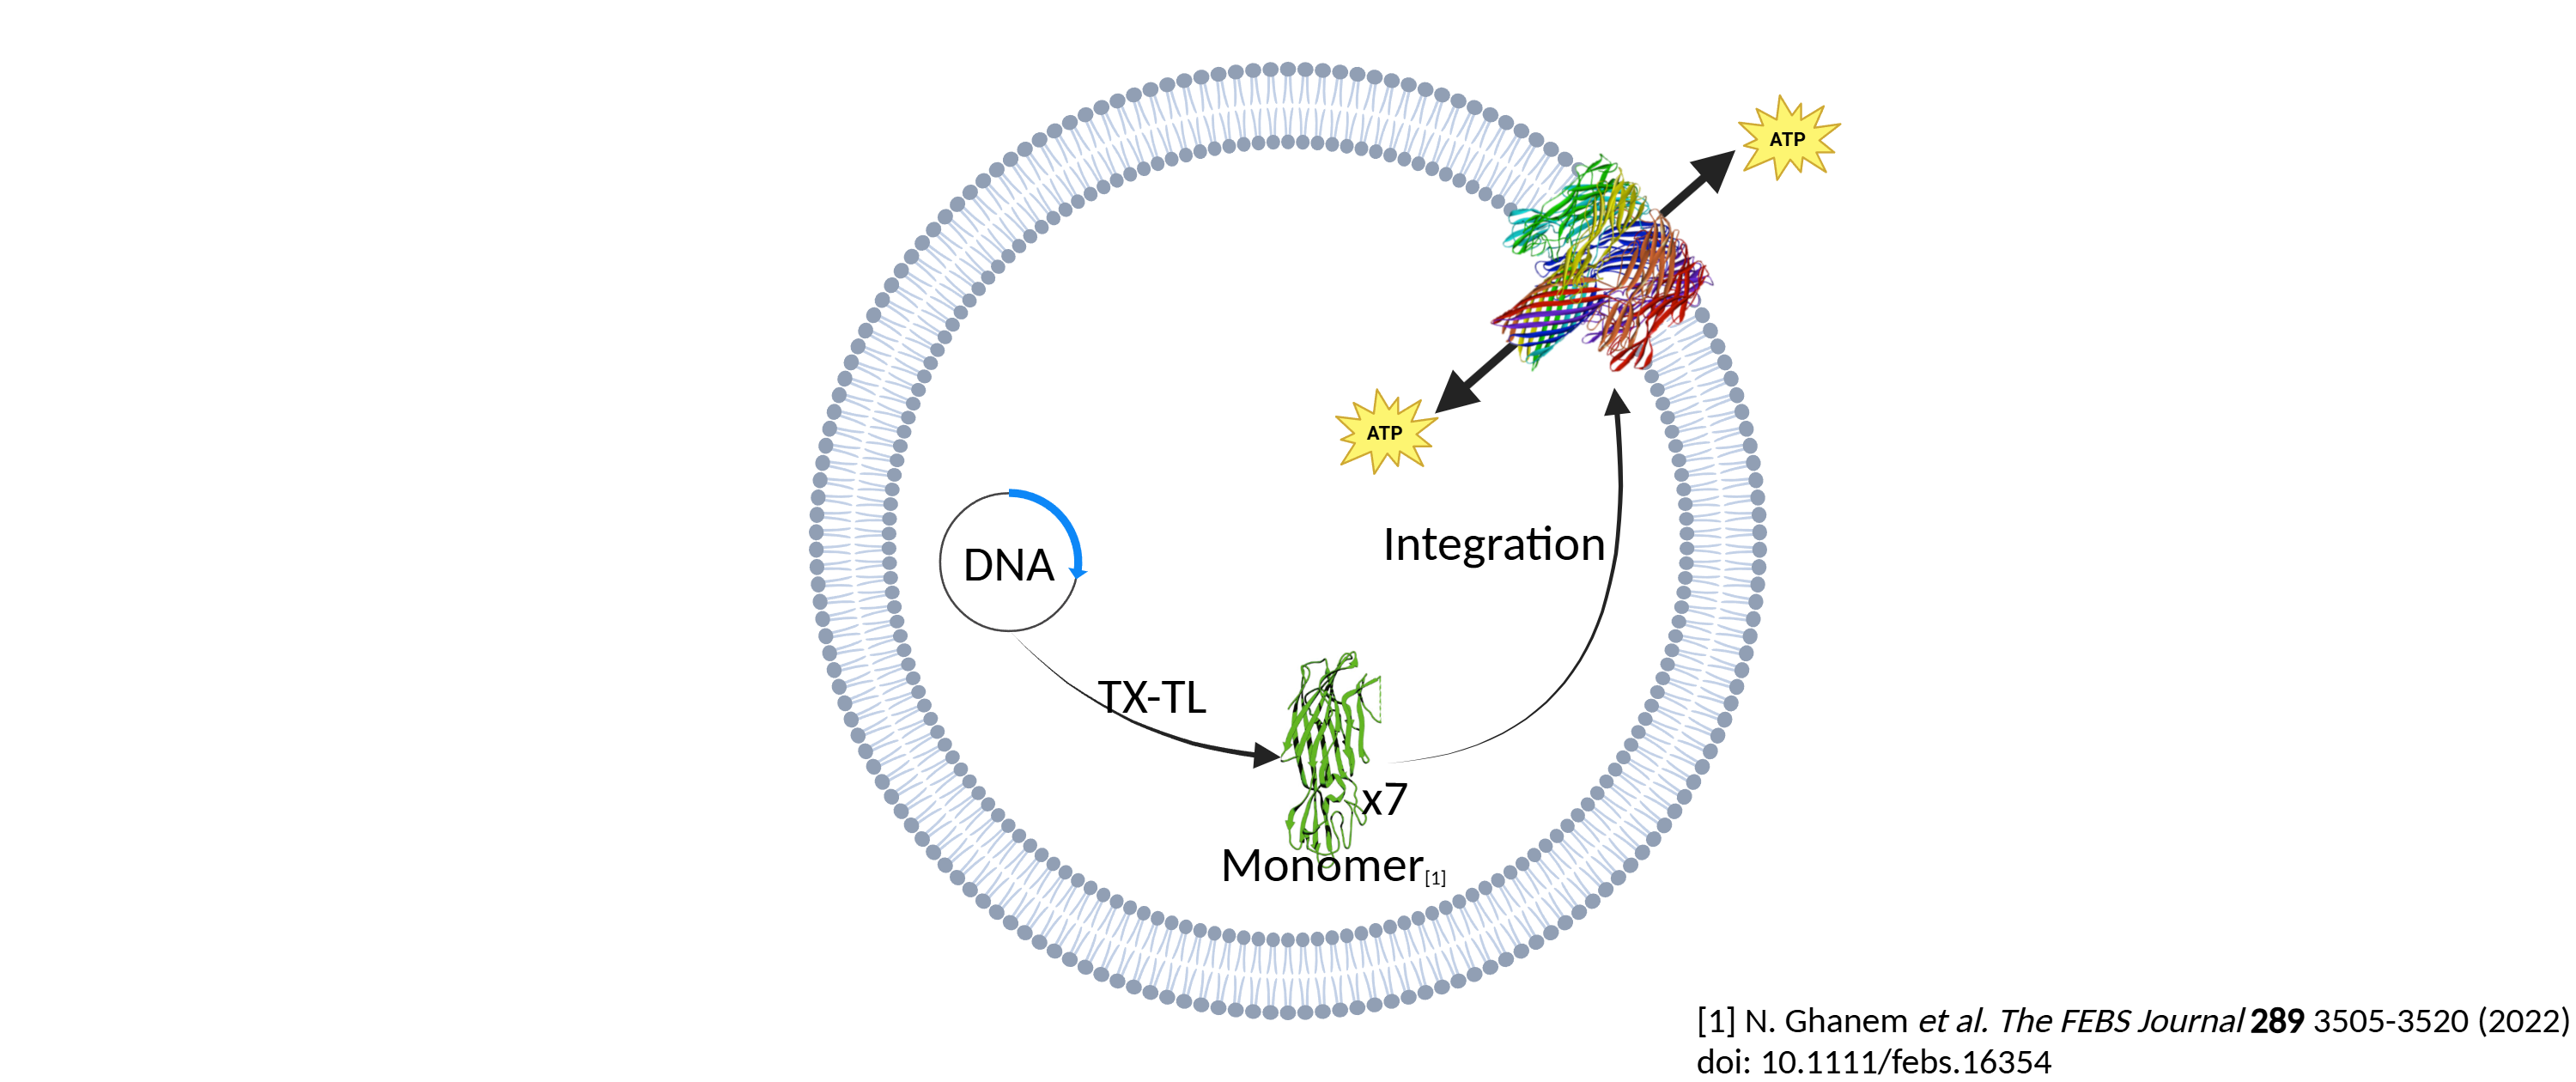
Consider the following substrate transport steps:
1. Expression of $\alpha$HL protein (monomer):
\begin{align}
    DNA_{\alpha HL} + TXTL_{Energy} \rightarrow \alpha HL_{monomer}
\end{align}
2. Assemble into a homoheptamer:
\begin{align}
    7\alpha HL_{monomer} \rightarrow \alpha HL_{homoheptamer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    \alpha HL_{homoheptamer} \rightarrow \alpha HL_{channel}
\end{align}
6. Diffusion of small molecules (i.e. ATP) across membrane:
\begin{align}
    ATP_{internal} +\alpha HL_{channel} \rightleftharpoons ATP_{external}+\alpha HL_{channel}
\end{align}

## Activatable expression of $\alpha$HL protein (monomer)

In [ ]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= "alphaHL_monomer")

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

In [ ]:
#Inital conditions
x0_dict= {'small_molecule_T7RNAP':1.2,}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 1)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

#Plot
p1 =create_custom_plot("alpha-hemolysin Expression", x_max=8,y_max=.1, yname='monomer (uM)')
p1.line(R["time"]/3600,  R['protein_alphaHL_monomer'], line_width = 3, alpha=.5)
        
bokeh.io.show(p1)

## Identify the membrane protein monomer

In [ ]:
alphaHL_monomer = IntegralMembraneProtein('alphaHL_monomer', product='alphaHL', size=7)

default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [alphaHL_monomer], parameters = default_parameters, mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False)) #(Species=3, Reactions=4)

## Define membrane channel and transport mechanism
Internal and external fractions of the substarte are created

In [ ]:
alphaHL_channel=MembraneChannel(alphaHL_monomer.product, substrate='ATP', cell=0)

default_parameters = {"k_trnsp":1e-1}

mech_cat = Simple_Transport()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [alphaHL_channel], parameters = default_parameters, mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Combine all mixtures

In [ ]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [ ]:
#Inital conditions
x0_dict= {'small_molecule_T7RNAP':1.2,alphaHL_channel.product:5,}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 100)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

In [ ]:
#Plot alpha-hemolysin protien and the multiple configurations
p2 =create_custom_plot("alpha-hemolysin Expression", x_max=8,y_max= .014, yname='monomer (uM)')
p2.line(R["time"]/3600,  R['protein_alphaHL_monomer'], line_width = 3, line_alpha=.5, color='red', legend_label='monomer')
p2.line(R["time"]/3600,  R['complex_protein_alphaHL_monomer_7x_'], line_width = 3, line_alpha=.5,color='yellow',legend_label='polymer')
p2.line(R["time"]/3600,  R['protein_alphaHL_Passive'], line_width = 3, line_alpha=.5,color='green',legend_label='channel')

#Plot the transport of substrate ATP
p3 =create_custom_plot("Passive Transport of ATP", x_max=18,y_max= 5, yname='ATP (uM)')
p3.line(R["time"]/3600,  R['ATP_External_0'], line_width = 3, legend_label = "External_substrate", color = 'orange')
p3.line(R["time"]/3600,  R['ATP_Internal_0'], line_width = 3, legend_label = "Internal_substrate", color =  'purple', line_dash = 'dashed')

# Arrange the plots in a row layout
layout = row(p2, p3)
# Display the layout
show(layout) # Display the layout

# Example 2: Integration of membrane protein (homdimer) and facilitated trasnport by a membrane carrier (ex. glucose and GLUT1)
GLUT1: A Facilitated Passive Diffusion Protein modeled as a monomer (though can form dimers and tetrameter)
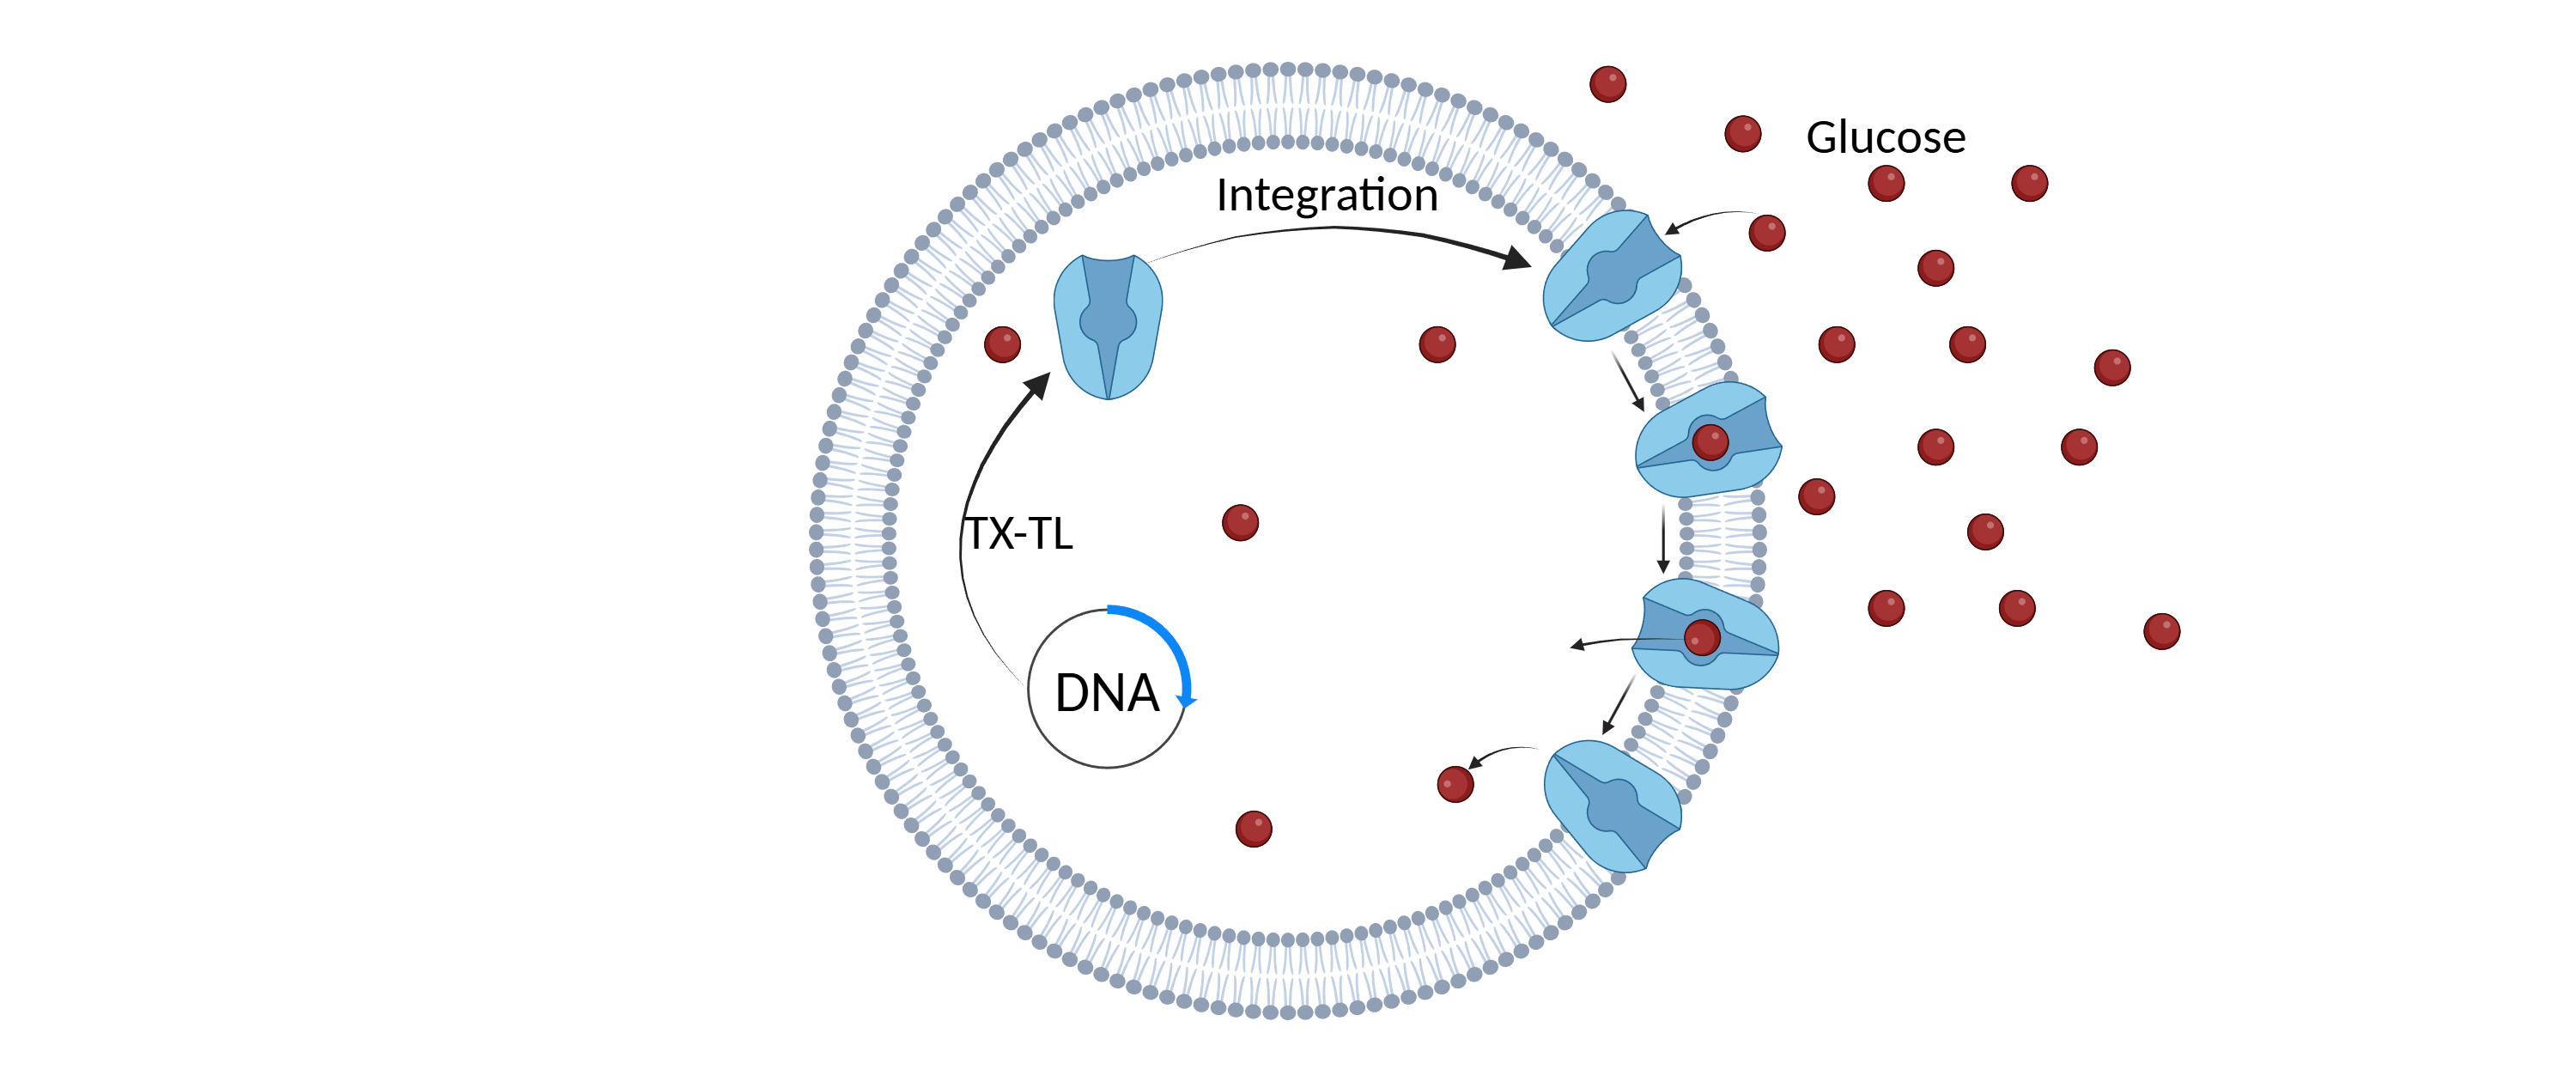
Consider the following substrate transport steps:
1. Expression of GLUT1 protein (monomer):
\begin{align}
    DNA_{GLUT1} + TXTL_{Energy} \rightarrow GLUT1_{monomer}
\end{align}
2. Integration of membrane protein in membrane:
\begin{align}
    GLUT1_{monomer} \rightarrow GLUT1_{channel}
\end{align}
3. Binding and transport of glucose across membrane:
\begin{align}
    glucose_{external} + GLUT1_{channel} \rightarrow glucose_{external}:GLUT1_{channel} \rightarrow glucose_{internal}:GLUT1_{channel}
\end{align}
4. Unbinding glucose from transporter:
\begin{align}
    glucose_{internal}:GLUT1_{channel} \rightarrow glucose_{internal} + GLUT1_{channel}
\end{align}

## Activatable expression of GLUT1 protein (monomer)

In [ ]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= "glut1")

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

## Identify the membrane protein monomer

In [ ]:
glut1 = IntegralMembraneProtein('glut1', product='glut1_channel', direction='Importer', size= 1)

default_parameters = {"kd1":5,"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kd2":5 }
mech_cat = Membrane_Protein_Integration()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [glut1], parameters = default_parameters, mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Define membrane channel and transport mechanism
Internal and external fractions of the substarte are created

In [ ]:
glut1_channel=MembraneChannel(glut1.product, substrate='glucose')

default_parameters = {"k_trnsp":1e-2, "ku1":1e-1,"ku2":1e-1, "k1":1e-1}

mech_cat = Facilitated_Transport_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [glut1_channel], parameters = default_parameters, mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Combine all mixtures

In [ ]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [ ]:
#Inital conditions
# x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':0,'glucose_Internal':5}
# x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':8,'glucose_Internal':5}
x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':5,'glucose_Internal':0}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 100)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

In [ ]:
#Plot alpha-hemolysin protien and the multiple configurations
p2 =create_custom_plot("glut1 Expression", x_max=8,y_max= .1, yname='monomer (uM)')
p2.line(R["time"]/3600,  R['protein_glut1'], line_width = 3, line_alpha=.5, color='red', legend_label='monomer')
p2.line(R["time"]/3600,  R['protein_glut1_channel_Importer'], line_width = 3, line_alpha=.5,color='green',legend_label='channel')

#Plot the transport of substrate ATP
p3 =create_custom_plot("Facilitated Transport of Glucose", x_max=18,y_max= 5, yname='ATP (uM)')
p3.line(R["time"]/3600,  R['glucose_External'], line_width = 3, legend_label = "External_substrate", color = 'orange')
p3.line(R["time"]/3600,  R['glucose_Internal'], line_width = 3, legend_label = "Internal_substrate", color =  'purple', line_dash = 'dashed')

# Arrange the plots in a row layout
layout = row(p2, p3)
# Display the layout
show(layout) # Display the layout

# Example 3: Integration of membrane protein (homodimer) and active transport by a membrane pump (ex. antibiotic and MsbA)
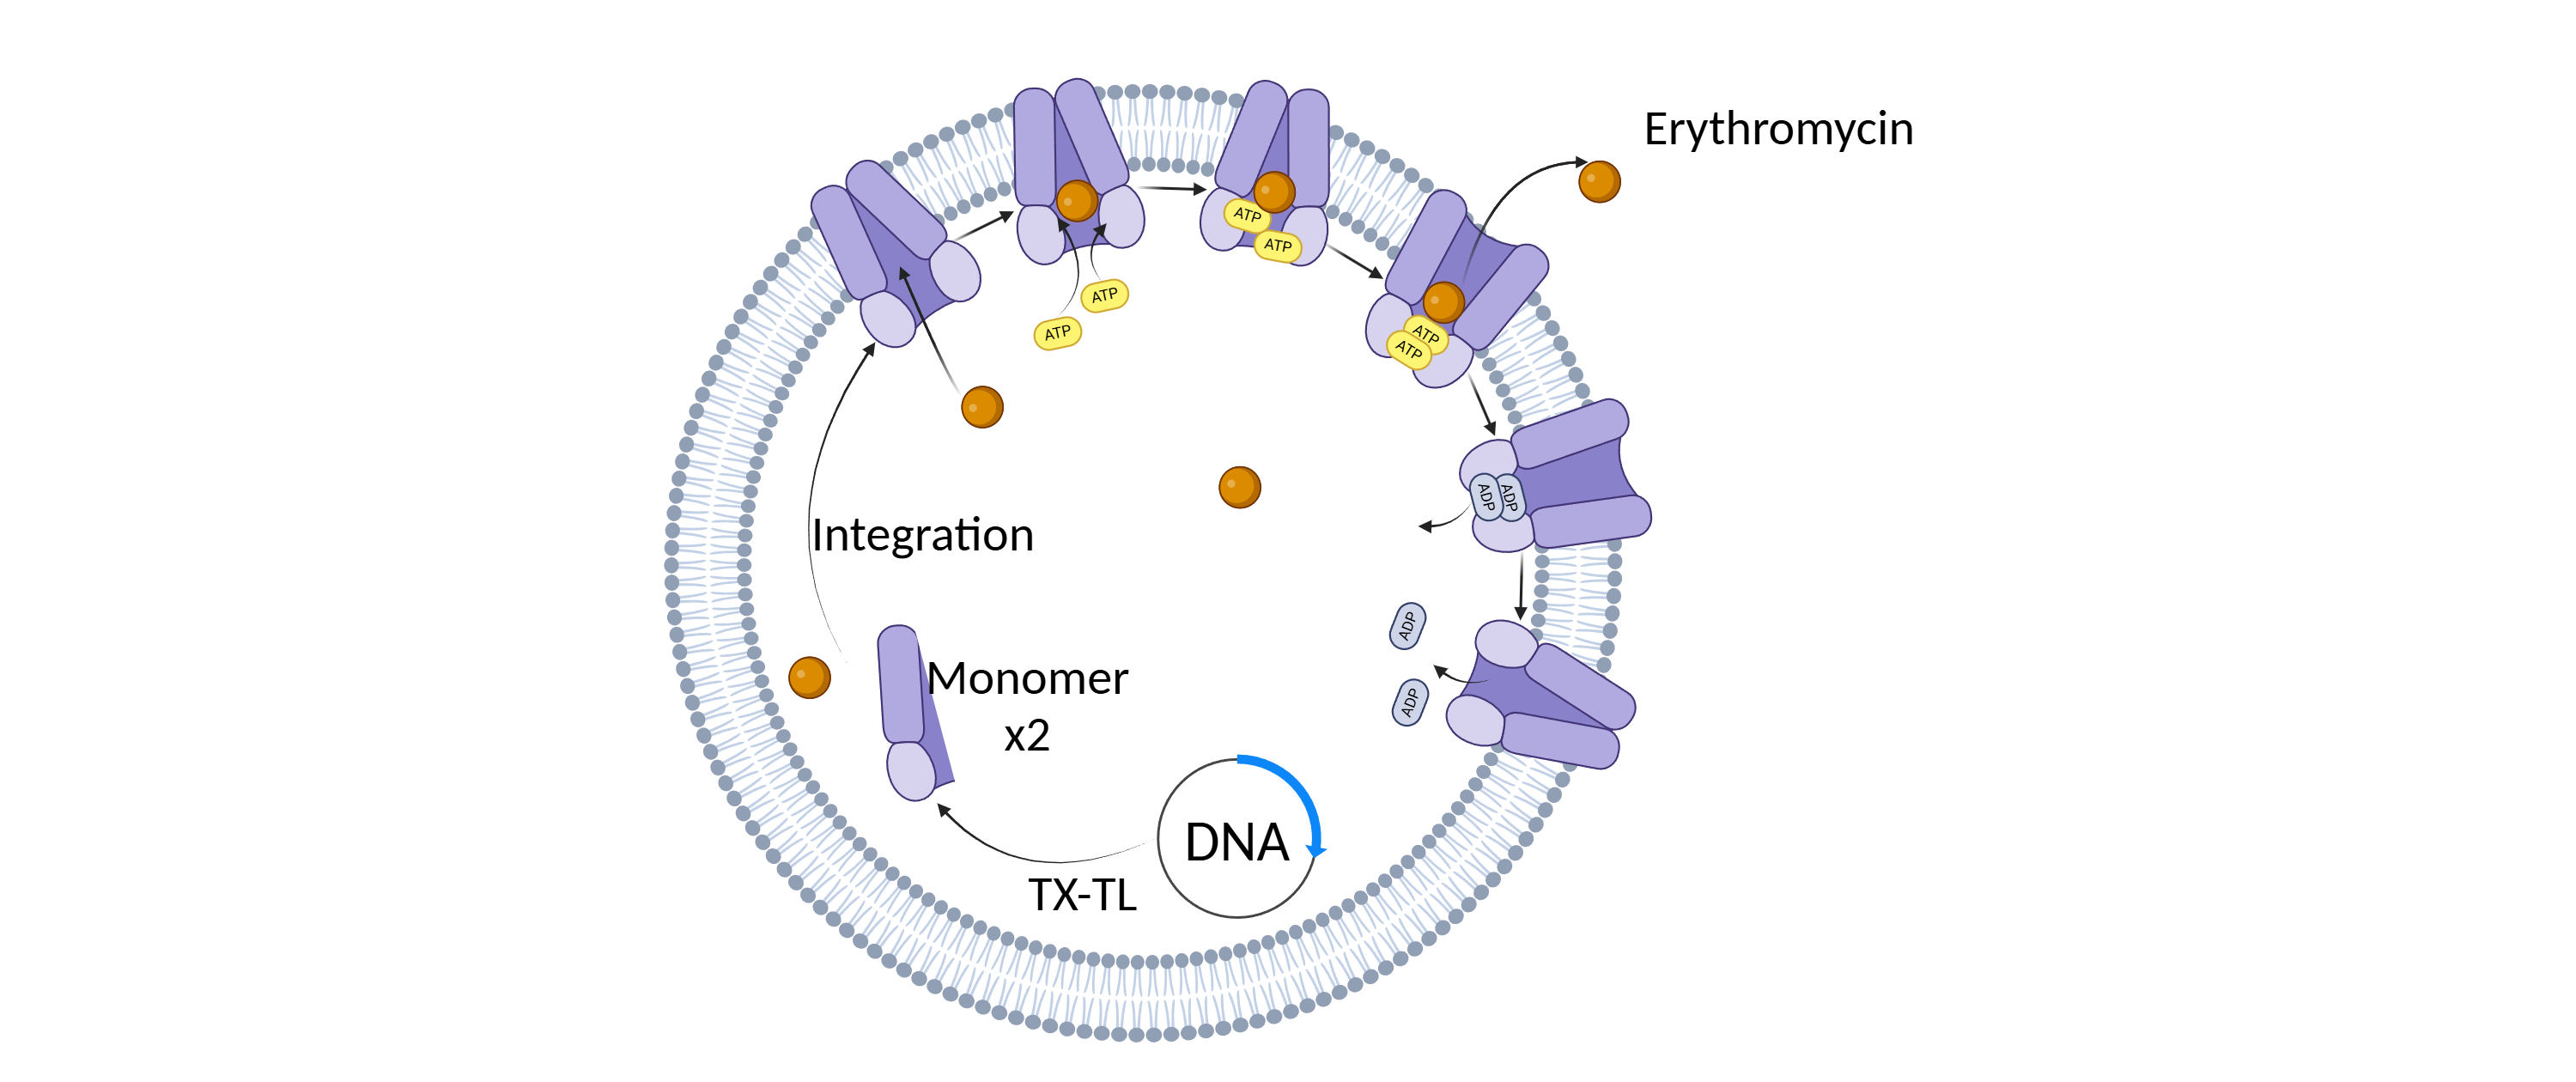
Consider the following substrate transport steps:
1. Expression of MsbA protein (monomer):
\begin{align}
    DNA_{MsbA} + TXTL_{Energy} \rightarrow MsbA_{monomer}
\end{align}
2. Assemble into a homodimer:
\begin{align}
    2MsbA_{monomer} \rightarrow MsbA_{homodimer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    MsbA_{homodimer} \rightarrow MsbA_{exporter}
\end{align}
4. Binding of antibiotic (Abx) substrate (i.e. erythromycin) to MsbA transporter:
\begin{align}
    Abx_{internal}+ MsbA_{exporter} \rightleftharpoons Abx_{internal}:MsbA_{exporter}
\end{align}
5. Binding of ATP to complex of erythromycin with MsbA:
    \begin{align}
        2ATP_{internal} + Abx_{internal}:MsbA_{exporter} \rightleftharpoons 2ATP_{internal}:Abx_{internal}: MsbA_{exporter}
    \end{align}
6. Export of erythromycin lipid from inner membrane to outer membrane:
    \begin{align}
        2ATP_{internal}:Abx_{internal}:MsbA_{exporter} \rightarrow 2ATP_{internal}:Abx_{external}:MsbA_{transporter}
    \end{align}
7. Unbinding of erythromycin:
    \begin{align}
        2ATP_{internal}:Abx_{external}:MsbA_{exporter} \rightarrow 2ADP_{internal}:MsbA_{exporter} + Abx_{external}
    \end{align}
8. Unbinding of ADP with MsbA:
    \begin{align}
        2ADP_{internal}:MsbA_{exporter} \rightarrow 2ADP_{internal}:MsbA_{exporter}
    \end{align}

## Activatable expression of MsbA protein (monomer)

In [ ]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= "MsbA_monomer")

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

## Identify the membrane protein monomer

In [ ]:
MsbA_monomer = IntegralMembraneProtein('MsbA_monomer', product='MsbA_pump', size=2, direction='Exporter')

default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() #cant be 0

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [MsbA_monomer], parameters = default_parameters, mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False)) #(Species=3, Reactions=4)

## Define membrane channel and transport mechanism
Internal and external fractions of the substarte are created

In [ ]:
MsbA_pump=MembranePump(MsbA_monomer.product, substrate='Abx', ATP=2, cell=0)

default_parameters = {"k1":1e-1, "ku1":0.1, "k2":1e-1, "ku2":1e-2,
                      "k_trnsp":1e-2,"ku3":.1,"ku4":.1,}
                      # "kb3":.1,"kb4":.1, "kcat":10., "kb1":100, "ku6":.1,"ku5":.1,
                     
                      # "kex":.3,"kcat_rev":0.1, 

mech_cat = Primary_Active_Transport_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2= Mixture("Default Param Pathway", components = [MsbA_pump], parameters = default_parameters, mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Combine all mixtures

In [ ]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

# print("Writing the CRN model as an SBML file (to output, exchange, standardize the model)...")
# CRN.write_sbml_file('ExporterMemTransporter_Test.xml');
# print(CRN.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

In [ ]:
#Inital conditions
x0_dict= {'small_molecule_T7RNAP':1.2, 'Abx_Internal_0':1,'Abx_External_0':1,'small_molecule_ATP_Internal_0':100}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 1000)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

In [ ]:
#Plot alpha-hemolysin protien and the multiple configurations
p2 =create_custom_plot("MsbA Expression", x_max=20,y_max= .04, yname='monomer (uM)')
p2.line(R["time"]/3600,  R['protein_MsbA_monomer'], line_width = 3, line_alpha=.5, color='red', legend_label='monomer')
p2.line(R["time"]/3600,  R['complex_protein_MsbA_monomer_2x_'], line_width = 3, line_alpha=.5,color='yellow',legend_label='dimer')
p2.line(R["time"]/3600,  R['protein_MsbA_pump_Exporter'], line_width = 3, line_alpha=.5,color='green',legend_label='channel')

#Plot the transport of substrate ATP
p3 =create_custom_plot("Active Transport of Abx", x_max=18,y_max= 2.1, yname='Abx (uM)')
p3.line(R["time"]/3600,  R['Abx_External_0'], line_width = 3, legend_label = "External", color = 'orange')
p3.line(R["time"]/3600,  R['Abx_Internal_0'], line_width = 3, legend_label = "Internal", color =  'purple', line_dash = 'dashed')

# Arrange the plots in a row layout
layout = row(p2, p3)
# Display the layout
show(layout) # Display the layout

# Example 4: Integration of membrane protein (homodimer) and two-component regulatory system (NarX-L). 
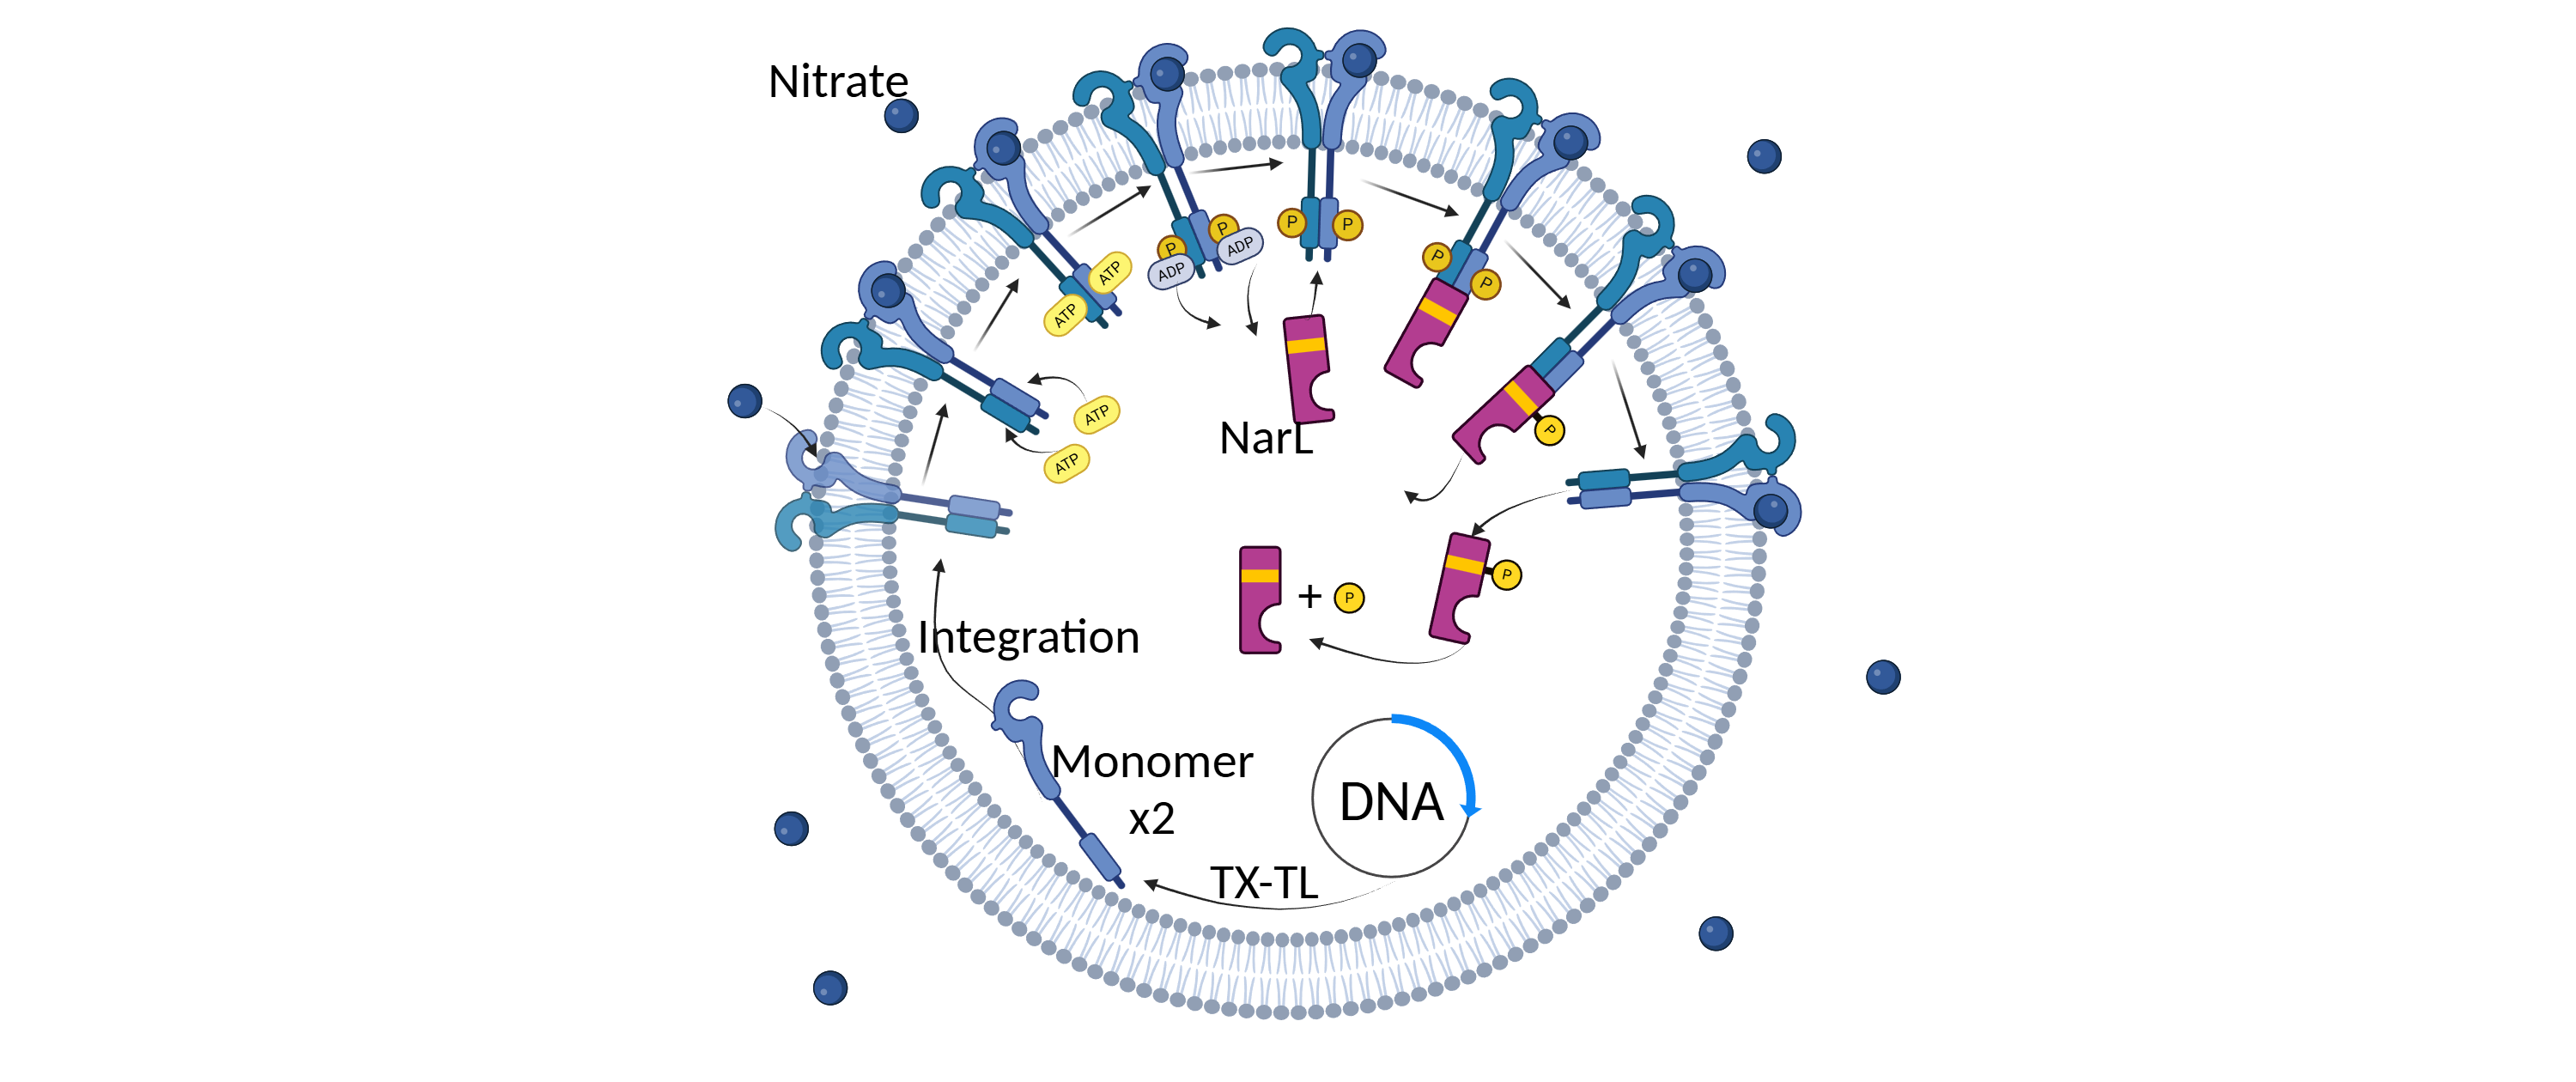
Consider the following signal transduction pathways:
1. Expression of NarX protein (monomer):
\begin{align}
    DNA_{NarX} + TXTL_{Energy} \rightarrow NarX_{monomer}
\end{align}
2. Assemble into a homodimer:
\begin{align}
    2NarX_{monomer} \rightarrow NarX_{homodimer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    NarX_{homodimer} \rightarrow NarX_{sensor}
\end{align}
4. Detecting and binding to nitrate (NO3):
\begin{align}
    NarX_{sensor} +  NO_3 \rightleftharpoons NarX_{sensor}:NO_3 \equiv NarX^*_{sensor}
\end{align}
5. Auto-phosphorylation membrane sensor (NarX):
\begin{align}
    NarX^*_{sensor} +  2ATP_{internal} \rightleftharpoons NarX^*_{sensor}:2ATP_{internal} \rightarrow NarX^{*2P_i}_{sensor}:2ADP_{internal}\rightarrow NarX^{*2P_i}_{sensor}+2ADP_{internal}
\end{align}
6. Phosphorylation of response protein (NarL):
\begin{align}
    NarX^{*2P_i}_{sensor}+NarL \rightleftharpoons NarX^{*2P_i}_{sensor}:NarL \rightarrow NarX^{*}_{sensor}:NarL^{*} \rightarrow NarX^{*}_{sensor}+NarL^{*}
\end{align}
7. Dephosphorylation of phosphoryled response protein (NarL*):
\begin{align}
    NarL^{*} \rightarrow  NarL + P_i
\end{align}

## Activatable expression of NarX protein (monomer)

In [ ]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= "NarX_monomer")

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print()) #(Species=14, Reactions=10)

In [ ]:
#Inital conditions
x0_dict= {'small_molecule_T7RNAP':1.2,}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 1)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

#Plot
p1 =create_custom_plot("NarX Expression", x_max=8,y_max=.1, yname='monomer (uM)')
p1.line(R["time"]/3600,  R['protein_NarX_monomer'], line_width = 3, alpha=.5)
        
bokeh.io.show(p1)

## Identify the membrane protein monomer

In [ ]:
NarX_monomer = IntegralMembraneProtein('NarX_monomer', product='NarX', size=2)

default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [NarX_monomer], parameters = default_parameters, mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False)) #(Species=3, Reactions=4)

## Define membrane channel and transport mechanism
Internal and external fractions of the substarte are created

In [ ]:
NarX_sensor=MembraneSensor(NarX_monomer.product, response_protein= 'NarL',
                            assigned_substrate='P', signal_substrate='NO3',ATP=2)

default_parameters = {"kb1":2e-3, "ku1": 2e-10, "kb2":2e-3, "ku2": 2e-10,
                      "k_hydro":1e-1, "ku3": 2e-1, "kb4":2e-3, "ku4": 2e-10,
                      "k_phosph":1e-1, "ku5": 2e-1,"ku6":2e-10,}

mech_cat = Membrane_Signaling_Pathway_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [NarX_sensor], parameters = default_parameters, mechanisms = default_mechanisms)
#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Combine all mixtures

In [ ]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [ ]:
#Inital conditions
x0_dict= {'small_molecule_T7RNAP':5,'NO3_Internal':0.02,'NarL_Internal':.04,'small_molecule_ATP_Internal':3}

# Simulate CRN
maxtime = 300000
timepoints = np.arange(0, maxtime, 100)

#Run Simulation
R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

In [ ]:
#Plot alpha-hemolysin protien and the multiple configurations
p2 =create_custom_plot("NarX phosphorylation of NarL", x_max=20,y_max= .04, yname='protein (uM)')
p2.line(R["time"]/3600,  R['protein_NarX_Passive'], line_width = 3, line_alpha=.5, color='red', legend_label='NarX')
p2.line(R["time"]/3600,  R['complex_NO3_Internal_protein_NarX_Passive_'], line_width = 3, line_alpha=.5,color='yellow',legend_label='NarX*')
p2.line(R["time"]/3600,  R['complex_P_Internal_complex_NO3_Internal_protein_NarX_Passive__'], line_width = 3, line_alpha=.5,color='green',legend_label='NarX*:2P')
p2.legend.click_policy="hide"

# #Plot the transport of substrate ATP
p3 =create_custom_plot("Passive Transport of ATP", x_max=20,y_max= .04, yname='ATP (uM)')
p3.line(R["time"]/3600,  R['NarL_Internal'], line_width = 3, line_alpha=.5,color='green',legend_label='NarL')
p3.line(R["time"]/3600,  R['complex_NarL_Internal_P_Internal_'], line_width = 3, line_alpha=.5,color='blue',legend_label='NarL*')
p3.legend.click_policy="hide"

# Arrange the plots in a row layout
layout = row(p2, p3)
# Display the layout
show(layout) # Display the layout